<a href="https://colab.research.google.com/github/raamav/Text-Classification/blob/master/Twitter_for_PublicEmergencies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Real or NOT" : NLP to Identify Public Emergency Related Tweets


## Introduction

Being able to predict which Tweets are about real Public Emergencies (*eg Earthquakes, Floods, Terrorist Events*) and which ones are not. 

(The words 'Pubic Emergency' and 'Disasters' have been used interchangeably)

> Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

> But, it’s not always clear whether a person’s words are actually announcing a disaster. 

*Source: [Real or Not? NLP with Disaster Tweets, A Kaggle Competition](https://www.kaggle.com/c/nlp-getting-started/overview)*

<BR>

### Goal

This is the second exploration of the dataset. In the 1st attempt an ensemble of ensemble methods yielded 80% accuracy on the test data. 

The goal is to get a better model using Deep Learning.

**Note: This notebook lays more emphasis on model building as the orevious notebook features extensive data exploration.**

<BR>

### Approach Summary
*TBD*

<BR>

### Results
*tbd*

<BR>

***


## Data Exploration & Pre-Processing

In [123]:
# STANDARD IMPORTS

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

tf.__version__


'2.2.0-rc3'

In [0]:
# A CUSTOM FUNCTION FOR CREATING WORDCLOUDS
# AUTHOR: KAVITA GANESAN, https://kavita-ganesan.com/ 

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


def plot_wordcloud(text, max_words=400, 
                   min_font_size= 4 ,max_font_size=120,
                   min_word_lengthint = None,
                   figure_size=(24.0,16.0), 
                   title = None, title_size=40, 
                   mask = None):
    
    stopwords = set(STOPWORDS)
    
    more_stopwords = {'None'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    width = 1200,
                    height = 800,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    min_font_size = min_font_size,
                    random_state = 42,
                    mask = None)
    
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    
    plt.imshow(wordcloud);
    plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    


In [0]:
data = pd.read_csv("https://raw.githubusercontent.com/raamav/Text-Classification/master/train.csv")

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


One of the first steps is to divide the data into training, validation and test sets. Will be adopting a 70:15:15 split for this purpose

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.3, random_state = 42)
val, test = train_test_split(test, test_size = 0.5, random_state = 42)

In [128]:
print("train.shape", train.shape)
print("val.shape", val.shape)
print("test.shape", test.shape)

train.shape (5329, 5)
val.shape (1142, 5)
test.shape (1142, 5)


Exploring the data, and building functions (and/or pipelines) for preprocessing data. Will also explore the possibility of crating features (although deep learning models do not require extensive feature engineering)

In [129]:
train.head(5)

,id,keyword,location,text,target
1186,1707,bridge%20collapse,NaN,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0
4071,5789,hail,"Carol Stream, Illinois",GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,1
5461,7789,police,Houston,CNN: Tennessee movie theater shooting suspect ...,1
5787,8257,rioting,NaN,Still rioting in a couple of hours left until ...,1
7445,10656,wounds,Lake Highlands,Crack in the path where I wiped out this morni...,0


In [130]:
# COUNTS OF NULL VALUES FOR VARIOUS VARIABLES

train.isnull().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [131]:
# SETTING THE NULL VALUES AS 'None'

train = train.fillna('None')
val = val.fillna('None')
test = test.fillna('None')

# RECHECKING NULL COUNT
print("\nTrain",train.isnull().sum())
print("\nVal",val.isnull().sum())
print("\nTest",test.isnull().sum())


Train id          0
keyword     0
location    0
text        0
target      0
dtype: int64

Val id          0
keyword     0
location    0
text        0
target      0
dtype: int64

Test id          0
keyword     0
location    0
text        0
target      0
dtype: int64


In [132]:
train.head(2)

,id,keyword,location,text,target
1186,1707,bridge%20collapse,None,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0
4071,5789,hail,"Carol Stream, Illinois",GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,1


The `id` variable isn't really needed so getting rid of it across all the datasets

In [0]:
train = train.drop('id',1)
val = val.drop('id',1)
test = test.drop('id',1)

In [134]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5329 entries, 1186 to 7270
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   5329 non-null   object
 1   location  5329 non-null   object
 2   text      5329 non-null   object
 3   target    5329 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 208.2+ KB


In [135]:
# WHICH ARE THE TOP KEYWORDS

keyword_var = pd.DataFrame(train['keyword'].value_counts())

keyword_var[1:21] # Excluding 'None' which is the top keyword



,keyword
damage,36
siren,35
wreckage,34
fatalities,33
deluge,31
emergency,30
fear,30
harm,30
nuclear%20reactor,30
twister,30


In [136]:
# WHICH ARE THE TOP LOCATIONS

location_var = pd.DataFrame(train['location'].value_counts())

location_var[1:20] # Excluding 'None' which is the top keyword


,location
USA,77
New York,48
United States,38
London,34
Canada,23
UK,19
Mumbai,17
Nigeria,17
"Los Angeles, CA",17
Worldwide,16


In [137]:
! pip install contractions
import contractions

In [0]:
# FUNCTION TO IMPLEMENT BASIC TEXT PREPROCESSING : LOWER-CASING & REMOVING NUMBERS/PUNCTUATION

import re
import string
import contractions


def basic_preprocessor(text):
  
  import re
  import string
  import contractions
  

  # EXPANDING OUT CONTRACTIONS
  # e.g : don't -> do not
  text = contractions.fix(text)

  # TEXT TO LOWERCASE
  text = text.lower()

    
  # The syntax of re.sub() is:: re.sub(pattern, replace, source_string)
    
  # CODE TO HANDLE POSSESSIVES ('s) 
  # e.g: movie's -> movie s
  # THE HOPE IS THAT LSTMs SHOULD BE ABLE TO PROCESS "s" 
  text = re.sub(r"(\w+)'s", r'\1 s', text)
  
  # HANDLING OTHER PUNCTUATION
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
    
  return text

In [0]:
# EXPERIMENTING

sample = train.apply(lambda x: basic_preprocessor(x['text']),axis=1)


In [140]:
for i in range(1,11):
  print("\n", train['text'].iloc[i])
  print( sample.iloc[i])


 GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj
great michigan technique  thanks to  hailyoutsey   goblue wrestleon 

 CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR
cnn tennessee movie theater shooting suspect killed by police 

 Still rioting in a couple of hours left until I have to be up for class.
still rioting in a couple of hours left until i have to be up for class

 Crack in the path where I wiped out this morning during beach run. Surface wounds on left elbow and right knee. http://t.co/yaqRSximph
crack in the path where i wiped out this morning during beach run surface wounds on left elbow and right knee 

 Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on... http://t.co/TagZbcXFj0 #MLB
experts in france begin examining airplane debris found on reunion island french air accident experts on  mlb

 'I ca

In [0]:
# PREPROCESSING THE TRAINING, VAL AND TEST SETS
train['text'] = train.apply(lambda x: basic_preprocessor(x['text']),axis=1)

val['text'] = val.apply(lambda x: basic_preprocessor(x['text']),axis=1)

test['text'] = test.apply(lambda x: basic_preprocessor(x['text']),axis=1)



Creating the initial model with just the text (contents of the tweet) variable.

In [0]:
X_train = train[['text']].copy()
y_train = train[['target']].copy()

X_val = val[['text']].copy()
y_val = val[['target']].copy()

X_test = test[['text']].copy()
y_test = test[['target']].copy()



## Building Vocabulary

In [0]:
# CALCULATING WORD FREQUENCY IN THE CORPUS
# AUTHOR: CRISTOF HENKEL, https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

import pandas as pd
from tqdm import tqdm
tqdm.pandas()

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [144]:
# IMPLEMENTING WORD FREQUENCY FUNCTION, STORING RESULTS IN master_vocab VARIABLE

sentences = X_train["text"].progress_apply(lambda x: x.split()).values
master_vocab = build_vocab(sentences)


100%|██████████| 5329/5329 [00:00<00:00, 246933.65it/s]

100%|██████████| 5329/5329 [00:00<00:00, 211795.80it/s]


In [145]:
# PRINTING OUT THE TOP K ENTRIES (k = 20)
print({k: master_vocab[k] for k in list(master_vocab)[:20]})

# TOP 50 WORDS
print("\n")
print(sorted(master_vocab, key = lambda x: (-master_vocab[x], x))[0:50])

# PRINTING OUT THE LENGTH OF THE VOCABULARY
print("Length of master vocabulary :", len(master_vocab))

{'ashes': 11, 'australia\x89ûªs': 2, 'collapse': 48, 'at': 377, 'trent': 9, 'bridge': 22, 'among': 8, 'worst': 14, 'in': 1391, 'history': 20, 'england': 8, 'bundled': 2, 'out': 198, 'australia': 15, 'for': 620, 'great': 44, 'michigan': 4, 'technique': 2, 'thanks': 22, 'to': 1407}


['the', 'a', 'to', 'in', 'i', 'of', 'and', 'is', 'you', 'for', 'on', 'not', 'it', 'my', 'that', 'with', 'are', 'at', 'by', 'have', 'this', 'from', 's', 'be', 'am', 'was', 'will', 'do', 'like', 'as', 'but', 'so', 'up', 'me', 'we', 'just', 'amp', 'your', 'out', 'can', 'no', 'after', 'all', 'has', 'when', 'fire', 'what', 'an', 'if', 'he']
Length of master vocabulary : 13333


## Using Pre-Trained Embeddings to Determine Extent of Data Standardization

In [146]:
# IMPORTING THE EMBEDDINGS
# AUTHOR: LAURENCE MORONEY, AI ADVOCATE AT GOOGLE 

# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

embeddings_index = {};

with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

--2020-04-27 06:31:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   117MB/s    in 2.8s    

2020-04-27 06:31:49 (117 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [147]:
# PRINT OUT THE LENGTH OF THE DICTIONARY

print("len(embeddings_index)",len(embeddings_index))

len(embeddings_index) 400000


In [0]:
# DEFINING FUNCTION CHECK OVERLAP BETWEEN master_vocab AND embeddings_index
# AUTHOR: CRISTOF HENKEL, https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [149]:
# IMPLEMENTING THE FUCNTION

oov = check_coverage(master_vocab,embeddings_index)


100%|██████████| 13333/13333 [00:00<00:00, 677776.43it/s]

Found embeddings for 73.18% of vocab
Found embeddings for  93.98% of all text


It is quite-promising that 73% of words have corresponding entries in the embedding file.

Exploring the Top-50 OOV words

In [150]:
oov[0:50]

[('\x89û', 39),
 ('\x89ûò', 24),
 ('prebreak', 23),
 ('re\x89û', 21),
 ('nowplaying', 19),
 ('typhoondevastated', 18),
 ('bestnaijamade', 16),
 ('\x89ûó', 15),
 ('gbbo', 14),
 ('disea', 13),
 ('lmao', 13),
 ('funtenna', 12),
 ('subreddits', 11),
 ('\x89ûïwhen', 10),
 ('gtgt', 10),
 ('yyc', 9),
 ('selfimage', 9),
 ('rea\x89û', 8),
 ('worldnews', 8),
 ('abstorm', 8),
 ('sensorsenso', 8),
 ('sismo', 7),
 ('arianagrande', 7),
 ('mediterran', 7),
 ('spos', 7),
 ('justinbieber', 6),
 ('freakiest', 6),
 ('ices\x89û', 6),
 ('trapmusic', 6),
 ('djicemoon', 6),
 ('icemoon', 6),
 ('rì©union', 6),
 ('animalrescue', 6),
 ('don\x89ûªt', 6),
 ('truthnewsbbccnnislamtruthgodisisterrorismquranlies', 6),
 ('i\x89ûªm', 5),
 ('dorret', 5),
 ('tcot', 5),
 ('å£', 5),
 ('prophetmuhammad', 5),
 ('chicagoarea', 5),
 ('directioners', 5),
 ('mtvhottest', 5),
 ('wheavenly', 5),
 ('nasahurricane', 5),
 ('viralspell', 5),
 ('by\x89û', 5),
 ('usagov', 5),
 ('strategicpatience', 5),
 ('can\x89ûªt', 5)]

In [0]:
# DEFINE A MIS-SPELLING DICTIONARY

mispell_dict = {
  'prebreak': 'pre break',
  'nowplaying': 'now playing',
  'typhoondevastated': 'typhoon devastated',
  'lmao': 'funny'
}


In [0]:
# WRITING A FUNCTION TO CLEAN THE ABOVE INCONSISTENCIES
# AUTHOR: CRISTOF HENKEL, https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings


import re

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


mispellings, mispellings_re = _get_mispell(mispell_dict)



def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

In [153]:
# IMPLEMENTING THE FUNCTION FOR TRAINING AND TEST SETS

X_train["text"] = X_train["text"].progress_apply(lambda x: replace_typical_misspell(x))
X_val["text"] = X_val["text"].progress_apply(lambda x: replace_typical_misspell(x))
X_test["text"] = X_test["text"].progress_apply(lambda x: replace_typical_misspell(x))



100%|██████████| 5329/5329 [00:00<00:00, 168388.96it/s]

100%|██████████| 1142/1142 [00:00<00:00, 150214.67it/s]

100%|██████████| 1142/1142 [00:00<00:00, 137415.59it/s]


In [0]:
# BLANK

## Tokenizing Text

(CANCELED THIS IDEA) Since the Tweets are of more or less the same length, I won't be imposing a 'maximum length' criteria.

In [0]:
# SPECIFYING HYPERPARAMETERS

vocab_size = 7000
embedding_dim = 20
max_length = 15  
trunc_type = 'post'
oov_tok = "<OOV>"

In [0]:
# IMPORTING LIBRARIES AND SETTING-UP TOKENIZER

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:
# IMPLEMENTING TOKENIZER

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)

tokenizer.fit_on_texts(X_train['text'])

In [193]:
# PADDING SEQUENCES - TRAINING SET

X_train_seq = tokenizer.texts_to_sequences(X_train['text'])

print("length of the first training sequence: ",len(X_train_seq[0])) 
      
X_train_pad = pad_sequences(X_train_seq,maxlen = max_length, padding = 'post', truncating = trunc_type)

print("length of the first training sequence (PADDED): ",len(X_train_pad[0])) 

length of the first training sequence:  15
length of the first training sequence (PADDED):  15


In [194]:
# TOKENIZATION AND PADDING ON VALIDATION DATA

X_val_seq = tokenizer.texts_to_sequences(X_val['text'])

print("length of the first test sequence: ",len(X_val_seq[0])) 
      
X_val_pad = pad_sequences(X_val_seq, padding = 'post',maxlen = max_length, truncating = trunc_type)

print("length of the first training sequence (PADDED): ",len(X_val_pad[0])) 


length of the first test sequence:  9
length of the first training sequence (PADDED):  15


In [195]:
# TOKENIZATION AND PADDING ON TEST DATA

X_test_seq = tokenizer.texts_to_sequences(X_test['text'])

print("length of the first test sequence: ",len(X_test_seq[0])) 
      
X_test_pad = pad_sequences(X_test_seq, maxlen = max_length,padding = 'post', truncating = trunc_type)

print("length of the first training sequence (PADDED): ",len(X_test_pad[0])) 


length of the first test sequence:  14
length of the first training sequence (PADDED):  15


In [196]:
print(type(X_train_pad))
print(X_train_pad.shape)
print(X_val_pad.shape)
print(X_test_pad.shape)

<class 'numpy.ndarray'>
(5329, 15)
(1142, 15)
(1142, 15)


In [197]:
X_train_pad[0:3]

array([[ 947, 3285,  164,   19, 1117,  494, 1231,  780,    5,  557, 1232,
        3286,   40,  736,   11],
       [ 179, 2038, 3287,  495,    4, 4976, 4977, 4978,    0,    0,    0,
           0,    0,    0,    0],
       [1118, 1735,  222, 1031,  496,  590,  122,   20,   82,    0,    0,
           0,    0,    0,    0]], dtype=int32)

## LSTM BASED MODEL

In [198]:
# CLEAR BACKEND DATA

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


# CREATE AN LSTM BASED NEURAL NETWORK IN KERAS


sentence_length = max_length  # LENGTH OF EACH PADDED SENTENCE = 18


lstm_model = keras.models.Sequential([
                                          
                  keras.layers.Embedding(input_dim = vocab_size + 1,
                                         output_dim = embedding_dim,
                                         input_length = sentence_length),
                          
                  
                  keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences = True, dropout = 0.1, recurrent_dropout= 0.1)),
                  keras.layers.Bidirectional(keras.layers.LSTM(32)),


                  keras.layers.Dense(64, activation = "relu"),
                  keras.layers.Dropout(rate = 0.2),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(32, activation = "relu"),
                  keras.layers.Dropout(rate = 0.2),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(1, activation = "sigmoid")
                  
])



# VIEW MODEL ARCHITECTURE
lstm_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 20)            140020    
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 128)           43520     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [199]:
# IMPLEMENT CALLBACKS

checkpoint_cb = keras.callbacks.ModelCheckpoint("twtr_lstm_best.h5",save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)




# COMPILE AND FIT MODEL

lstm_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['accuracy'])

history_1 = lstm_model.fit(X_train_pad,y_train, epochs = 20,
                            validation_data = (X_val_pad, y_val),
                            callbacks = [checkpoint_cb, early_stopping_cb]
                            
                            )

Epoch 1/20
167/167 [==============================] - 10s 61ms/step - loss: 0.6960 - accuracy: 0.6168 - val_loss: 0.6473 - val_accuracy: 0.7644
Epoch 2/20
167/167 [==============================] - 9s 54ms/step - loss: 0.4452 - accuracy: 0.8022 - val_loss: 0.5540 - val_accuracy: 0.7294
Epoch 3/20
167/167 [==============================] - 9s 54ms/step - loss: 0.3212 - accuracy: 0.8701 - val_loss: 0.4875 - val_accuracy: 0.7715
Epoch 4/20
167/167 [==============================] - 9s 54ms/step - loss: 0.2635 - accuracy: 0.8951 - val_loss: 0.5585 - val_accuracy: 0.7820
Epoch 5/20
167/167 [==============================] - 9s 54ms/step - loss: 0.2081 - accuracy: 0.9281 - val_loss: 0.5307 - val_accuracy: 0.7811
Epoch 6/20
167/167 [==============================] - 9s 53ms/step - loss: 0.1745 - accuracy: 0.9338 - val_loss: 0.6571 - val_accuracy: 0.7785
Epoch 7/20
167/167 [==============================] - 9s 53ms/step - loss: 0.1415 - accuracy: 0.9501 - val_loss: 0.7192 - val_accuracy: 0.768

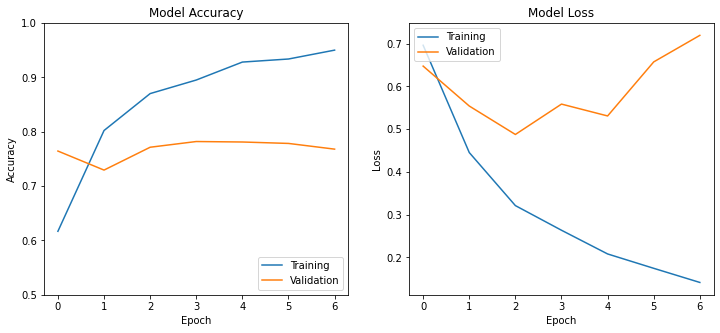

In [200]:
history = history_1


# BETTER LOOKING PLOTS FOR ACCURACY AND LOSS

import matplotlib.pyplot as plt

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_ylim([0.5,1])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Training', 'Validation'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Training', 'Validation'], loc='upper left')